# Anomaly Detection using web servers' logs

## Problem
We need to detect itrusioners and crawlers of a web server from its users' foot prints that provided for us as a log file.

It's an unsupervised problem becuase, there isn't any label for the anomalies, So we have to figure out them and find them from the log server.


In [13]:
# Import requirements
import re
import pandas as pd
import numpy as np
import tensorflow as tf

# !pip install pandas-profiling==2.7.1
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

# !pip install category_encoders
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

## Prepare data
1. Create a `.csv` from the provided logs.
2. Extract features.
3. Clean data:
  * Fix datetimes.
  * Fix missing values.
  * Figure out categories.
  * Check correlations.
4. Prepare data to fit our model:
  * Check the balences.
  * Split train, test.


In [ ]:
# !gzip --decompress drive/MyDrive/Rahnema-College/Tuning/Final-Project/output.log.gz

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Extract features from log files to build .csv format


In [ ]:
# Regex Pattern
pattern = '(?P<Client>\S+) \[(?P<Time>\S+)\] \[(?P<Method>\S+) (?P<Request>\S+)\] (?P<Status>\S+) (?P<Size>\S+) \[\[(?P<UserAgent>[\S\s]+)\]\] (?P<Duration>\S+)'
file_path = 'drive/MyDrive/Rahnema-College/Tuning/Final-Project/output.log'
columns = ["Client", "Datetime", "Method", "Request", "Status", "Length", "UserAgent", "ResponseTime"]

In [ ]:
# Find regex in our logs
def parse_data(file_path, pattern):
  """
  Return the part of data that extracted by given pattern.
  file_path -> Your log file.
  pattern -> The pattern that you're looking for in your logs.

  Return parsed_line -> as a list of finded data.
  """
  parsed_lines = []

  with open(file_path) as logs:
    for line in logs:
      try:
        finded_pattern = list(re.findall(pattern, line)[0])
        parsed_lines.append(finded_pattern)
      except Exception as e:
        print("There is an error while parsing data! Try Again :(")
  return parsed_lines

In [ ]:
extracted_features = parse_data(file_path, pattern)
extracted_features[0]

['207.213.193.143',
 '2021-5-12T5:6:0.0+0430',
 'Get',
 '/cdn/profiles/1026106239',
 '304',
 '0',
 'Googlebot-Image/1.0',
 '32']

In [ ]:
# Create a .csv format
data = pd.DataFrame(extracted_features, columns=columns)
data.head()

,Client,Datetime,Method,Request,Status,Length,UserAgent,ResponseTime
0,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32
1,207.213.193.143,2021-5-12T5:6:0.0+0430,Get,images/badge.png,304,0,Googlebot-Image/1.0,4
2,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32
3,35.108.208.99,2021-5-12T5:6:0.0+0430,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20
4,35.110.222.153,2021-5-12T5:6:0.0+0430,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8


In [ ]:
data.shape

(1260035, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260035 entries, 0 to 1260034
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Client        1260035 non-null  object
 1   Datetime      1260035 non-null  object
 2   Method        1260035 non-null  object
 3   Request       1260035 non-null  object
 4   Status        1260035 non-null  object
 5   Length        1260035 non-null  object
 6   UserAgent     1260035 non-null  object
 7   ResponseTime  1260035 non-null  object
dtypes: object(8)
memory usage: 76.9+ MB


### Fix time series

In [ ]:
# Convert datetimes to datetime format
data["Datetime"] = pd.to_datetime(data["Datetime"], format="%Y-%m-%dT%H:%M:%S")

In [ ]:
# Split datatimes
data['Year'] = data.Datetime.dt.year
data['Month'] = data.Datetime.dt.month
data['Day'] = data.Datetime.dt.day
data['Hour'] = data.Datetime.dt.hour
data['Minute'] = data.Datetime.dt.minute
data['Second'] = data.Datetime.dt.second
data['dayOfWeek'] = data.Datetime.dt.dayofweek
data['dayOfYear'] = data.Datetime.dt.dayofyear

In [ ]:
data.drop("Datetime", axis=1, inplace=True)

In [ ]:
data.head()

,Client,Method,Request,Status,Length,UserAgent,ResponseTime,Year,Month,Day,Hour,Minute,Second,dayOfWeek,dayOfYear
0,207.213.193.143,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32,2021,5,12,5,6,0,2,132
1,207.213.193.143,Get,images/badge.png,304,0,Googlebot-Image/1.0,4,2021,5,12,5,6,0,2,132
2,35.110.222.153,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,2021,5,12,5,6,0,2,132
3,35.108.208.99,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,2021,5,12,5,6,0,2,132
4,35.110.222.153,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,2021,5,12,5,6,0,2,132


### Split Requests
* Level_1
  * Level_2

In [ ]:
path_l1 = []
# paths_pattern = re.compile(r'^(\/|\w+)')
paths_pattern = re.compile(r'\S+\/|\/\S+')
for element in data.Request.values:
  finded_part = paths_pattern.findall(element)
  path_l1.append(finded_part)
path_l1[0]

['/cdn/profiles/']

In [ ]:
# Level Requests' path to make them more categorized
path_l1 = []
path_l2 = []
# paths_pattern = re.compile(r'^(\/|\w+)')
# paths_pattern = re.compile(r'\S+\/|\/\S+|\/')
paths_pattern = re.compile(r'^\/|^\w+\/')
for element in data.Request.values:
  finded_part = paths_pattern.findall(element)[0]
  path_l1.append(finded_part)
  path_l2.append(element.replace(finded_part, '', 1))

data["Req_Path_L1"] = path_l1
data["Req_Path_L2"] = path_l2

In [ ]:
data.head()

,Client,Method,Request,Status,Length,UserAgent,ResponseTime,Year,Month,Day,Hour,Minute,Second,dayOfWeek,dayOfYear,Req_Path_L1,Req_Path_L2
0,207.213.193.143,Get,/cdn/profiles/1026106239,304,0,Googlebot-Image/1.0,32,2021,5,12,5,6,0,2,132,/,cdn/profiles/1026106239
1,207.213.193.143,Get,images/badge.png,304,0,Googlebot-Image/1.0,4,2021,5,12,5,6,0,2,132,images/,badge.png
2,35.110.222.153,Get,/pages/630180847,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,2021,5,12,5,6,0,2,132,/,pages/630180847
3,35.108.208.99,Get,images/fav_icon2.ico,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,2021,5,12,5,6,0,2,132,images/,fav_icon2.ico
4,35.110.222.153,Get,images/sanjagh_logo_purpule5.png,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,2021,5,12,5,6,0,2,132,images/,sanjagh_logo_purpule5.png


In [ ]:
data["Req_Path_L1"].value_counts()

/             663910
images/       298288
js/           125224
fonts/         98485
css/           56303
templates/     17825
Name: Req_Path_L1, dtype: int64

In [ ]:
# Drop full Request Feature
data.drop("Request", axis=1, inplace=True)
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Year,Month,Day,Hour,Minute,Second,dayOfWeek,dayOfYear,Req_Path_L1,Req_Path_L2
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,2021,5,12,5,6,0,2,132,/,cdn/profiles/1026106239
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,2021,5,12,5,6,0,2,132,images/,badge.png
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,2021,5,12,5,6,0,2,132,/,pages/630180847
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,2021,5,12,5,6,0,2,132,images/,fav_icon2.ico
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,2021,5,12,5,6,0,2,132,images/,sanjagh_logo_purpule5.png


### Check Dataset & Fix Missing values


In [ ]:
# # Create a profile report
# profile = ProfileReport(data)
# profile.to_file("drive/MyDrive/Rahnema-College/Tuning/Final-Project/profile_report.html")a

In [ ]:
# Remove Constant features
constant_features = ["Year", "Month", "Day", "dayOfWeek", "dayOfYear"]
data.drop(constant_features, axis=1, inplace=True)

* There are some rows which don't have any values for `ResponseTime` and `Clinet` features. -> They must be dropped.
* Take care: some of rows contains `Clients'` value but no `ResponseTime` value. -> Their response time would be zero.

In [ ]:
data[(data["Client"] == '-') & (data["ResponseTime"] == '-')]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2
25,-,Get,301,169,kube-probe/1.21,-,5,6,1,/,
85,-,Get,301,169,kube-probe/1.21,-,5,6,3,/,
145,-,Get,301,169,kube-probe/1.21,-,5,6,5,/,
175,-,Get,301,169,kube-probe/1.21,-,5,6,7,/,
215,-,Get,301,169,kube-probe/1.21,-,5,6,9,/,
...,...,...,...,...,...,...,...,...,...,...,...
1259779,-,Get,301,169,kube-probe/1.21,-,15,8,51,/,
1259833,-,Get,301,169,kube-probe/1.21,-,15,8,53,/,
1259902,-,Get,301,169,kube-probe/1.21,-,15,8,55,/,
1259951,-,Get,301,169,kube-probe/1.21,-,15,8,57,/,


In [ ]:
data.head()

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2
0,207.213.193.143,Get,304,0,Googlebot-Image/1.0,32,5,6,0,/,cdn/profiles/1026106239
1,207.213.193.143,Get,304,0,Googlebot-Image/1.0,4,5,6,0,images/,badge.png
2,35.110.222.153,Get,200,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32,5,6,0,/,pages/630180847
3,35.108.208.99,Get,200,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20,5,6,0,images/,fav_icon2.ico
4,35.110.222.153,Get,200,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8,5,6,0,images/,sanjagh_logo_purpule5.png


In [ ]:
server_req = data.loc[(data["Client"] == '-') & (data["ResponseTime"] == '-')]
data.drop(server_req.index, axis=0, inplace=True)

In [ ]:
data[(data["Client"] != '-') & (data["ResponseTime"] == '-')]

,Client,Method,Status,Length,UserAgent,ResponseTime,Hour,Minute,Second,Req_Path_L1,Req_Path_L2
776,20.62.177.11,Get,200,53479,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,5,6,31,/,pros/1993352776
2010,20.62.177.60,Get,200,55330,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,5,7,27,/,pros/1797822247
2708,20.62.177.133,Get,200,20947,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,5,8,4,/,pros/763244865
2866,207.213.193.118,Get,301,169,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,-,5,8,18,/,pages/1939232229
3468,20.62.177.4,Get,200,37060,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,5,8,49,/,pros/2084824811
...,...,...,...,...,...,...,...,...,...,...,...
1257193,20.62.177.11,Get,200,24540,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,15,7,34,/,pros/1644096504
1257986,20.62.177.11,Get,200,36129,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,15,7,59,/,pros/743056796
1258079,20.62.177.161,Get,200,51334,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,-,15,8,2,/,pros/1177343248
1258456,207.213.207.17,Get,301,169,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,-,15,8,12,/,services/1404674245


In [ ]:
# Fill missing values for ResponseTime with 0
data.loc[(data["Client"] != '-') & (data["ResponseTime"] == '-'), "ResponseTime"] = '0'

In [ ]:
# Convert String to integers
data["Length"] = data["Length"].astype("int64")
data["ResponseTime"] = data["ResponseTime"].astype("int64")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241945 entries, 0 to 1260034
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Client        1241945 non-null  object
 1   Method        1241945 non-null  object
 2   Status        1241945 non-null  object
 3   Length        1241945 non-null  int64 
 4   UserAgent     1241945 non-null  object
 5   ResponseTime  1241945 non-null  int64 
 6   Hour          1241945 non-null  int64 
 7   Minute        1241945 non-null  int64 
 8   Second        1241945 non-null  int64 
 9   Req_Path_L1   1241945 non-null  object
 10  Req_Path_L2   1241945 non-null  object
dtypes: int64(5), object(6)
memory usage: 113.7+ MB


### Fix Categorical

* *Categorical features*: Method, Status, Client, UserAgent, Req_Path_L1, Req_Path_L2

**OneHot Encoded**: Method, Req_Path_L1 ✅️  
**Label Encoded**: Status ✅️  
**Hashing Encoded**: Client, UserAgent, Req_Path_L2

In [ ]:
# Status feature
data["Status"].value_counts()

200    765525
304    400543
101     61407
307      7704
404      2004
301      1635
499      1122
400       652
405       616
401       599
206        96
413        17
403        13
503         5
408         3
500         3
308         1
Name: Status, dtype: int64

In [ ]:
# Fix Status, Client, UserAgent features
data["Status"] = data["Status"].astype("category")
data["Status_cat"] = data["Status"].cat.codes+1

data["Client"] = data["Client"].astype("category")
data["Clients_cat"] = data["Client"].cat.codes+1

data["UserAgent"] = data["UserAgent"].astype("category")
data["UserAgents_cat"] = data["UserAgent"].cat.codes+1

data.drop(["Status", "Client", "UserAgent"], axis=1, inplace=True)

In [ ]:
data["Method"].value_counts()

Get        1123709
Put          65452
Post         32452
Head         20195
Options        137
Name: Method, dtype: int64

In [ ]:
data["Req_Path_L1"].value_counts()

/             645820
images/       298288
js/           125224
fonts/         98485
css/           56303
templates/     17825
Name: Req_Path_L1, dtype: int64

In [ ]:
# Fix Method & Req_Path_L1
ce_one = ce.OneHotEncoder(cols=["Method", "Req_Path_L1"])
prepared_data = ce_one.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# # Create a profile report
# profile = ProfileReport(data)
# profile.to_file("drive/MyDrive/Rahnema-College/Tuning/Final-Project/profile_report.html")

In [ ]:
# Fix Client, UserAgent, Req_Path_L2 which should be hashed
ce_hash = ce.HashingEncoder(cols=["Req_Path_L2"])
prepared_data = ce_hash.fit_transform(prepared_data)
prepared_data.head()

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Method_1,Method_2,Method_3,Method_4,Method_5,Length,ResponseTime,Hour,Minute,Second,Req_Path_L1_1,Req_Path_L1_2,Req_Path_L1_3,Req_Path_L1_4,Req_Path_L1_5,Req_Path_L1_6,Status_cat,Clients_cat,UserAgents_cat
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,32,5,6,0,1,0,0,0,0,0,5,11020,108
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4,5,6,0,0,1,0,0,0,0,5,11020,108
2,0,0,0,1,0,0,0,0,1,0,0,0,0,52567,32,5,6,0,1,0,0,0,0,0,2,15870,5125
3,0,0,0,1,0,0,0,0,1,0,0,0,0,23531,20,5,6,0,0,1,0,0,0,0,2,14671,5759
4,0,0,0,0,0,0,0,1,1,0,0,0,0,4680,8,5,6,0,0,1,0,0,0,0,2,15870,5125


In [ ]:
# Save Prepared Dataset
prepared_data.to_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/prepared_data.csv", index=False)

## Modeling

### Labeling samples
* K-Means
* Isolation Forest
* AutoEncoders

In [2]:
# Load prepared dataset
prepared_data = pd.read_csv("drive/MyDrive/Rahnema-College/Tuning/Final-Project/prepared_data.csv")

In [3]:
# Scaling ResponseTime, Length
scaler = StandardScaler()
prepared_data[["Length", "ResponseTime"]] = scaler.fit_transform(prepared_data[["Length", "ResponseTime"]])
prepared_data.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Method_1,Method_2,Method_3,Method_4,Method_5,Length,ResponseTime,Hour,Minute,Second,Req_Path_L1_1,Req_Path_L1_2,Req_Path_L1_3,Req_Path_L1_4,Req_Path_L1_5,Req_Path_L1_6,Status_cat,Clients_cat,UserAgents_cat
0,0,0,0,0,0,0,1,0,1,0,0,0,0,-0.137731,-0.036748,5,6,0,1,0,0,0,0,0,5,11020,108
1,0,0,1,0,0,0,0,0,1,0,0,0,0,-0.137731,-0.036899,5,6,0,0,1,0,0,0,0,5,11020,108
2,0,0,0,1,0,0,0,0,1,0,0,0,0,0.018056,-0.036748,5,6,0,1,0,0,0,0,0,2,15870,5125
3,0,0,0,1,0,0,0,0,1,0,0,0,0,-0.067995,-0.036813,5,6,0,0,1,0,0,0,0,2,14671,5759
4,0,0,0,0,0,0,0,1,1,0,0,0,0,-0.123861,-0.036878,5,6,0,0,1,0,0,0,0,2,15870,5125


In [4]:
prepared_data.shape

(1241945, 27)

In [5]:
# Create a function to fit models and get resul
def label_data(model, data=prepared_data, random_state=10):
  """
  Label samples given the model and dataset.
  """
  # Fit model
  model.fit(data)
  # Get a copy of data with samples' class predicted by the model
  predictions = data.copy()
  predictions["Class"] = model.predict(data)
  # Plot result
  predictions["Class"].value_counts().plot(kind="bar", grid=True)
  plt.title("Number of Samples in each Class");
  
  return predictions

#### KMeans

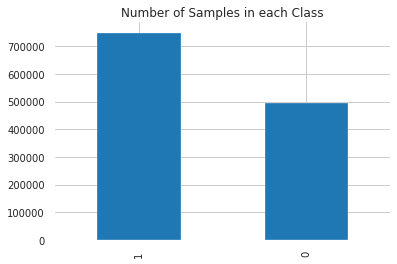

In [6]:
kmeans = KMeans(n_clusters=2, random_state=10)
kmeans_preds = label_data(kmeans)

In [7]:
kmeans_preds["Class"].value_counts()

1    748704
0    493241
Name: Class, dtype: int64

#### IsolationForest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

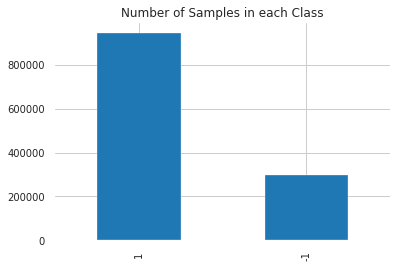

In [8]:
iForset = IsolationForest(n_estimators=10, random_state=10)
iForest_preds = label_data(iForset)

In [9]:
iForest_preds.Class.value_counts()

 1    945190
-1    296755
Name: Class, dtype: int64

In [10]:
iForset.decision_function(np.array(prepared_data))

array([-0.02800648, -0.00670248,  0.04121492, ...,  0.03891392,
        0.11607035,  0.07659833])

#### Guassian Mixture
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

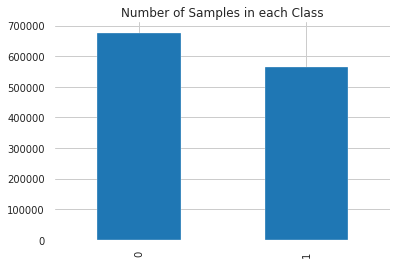

In [11]:
# Fit Gaussian Mixture models
gm = GaussianMixture(n_components=2, random_state=10)
gm_preds = label_data(gm)

In [12]:
gm_preds.Class.value_counts()

0    676316
1    565629
Name: Class, dtype: int64

### AutoEncoder

Train an AutoEncoder which detect anomalies in requests.

In [15]:
# Define a function to split data labeled by models
def split_data(data, target_label, test_size = 0.2, random_state = 10):
  """
  Split the data which labeled by a model and turn it into X_train, X_test, y_train, y_test.
  """
  np.random_state = random_state

  X = data.drop(target_label, axis=1)
  y = data.target_label

  X_train, X_test, y_train, y_test = train_test_split(X, y, )



array([  108.,   108.,  5125., ..., 11301.,   108.,   108.])